In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression,  LogisticRegressionCV, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import joblib

In [ ]:
df = pd.read_excel('/content/HealthCareData.xlsx')
pd.set_option('display.max_columns', None)

In [ ]:
df.describe()

,Age,Duration of alcohol consumption(years),Quantity of alcohol consumption (quarters/day),TCH,HDL,Hemoglobin (g/dl),PCV (%),MCV (femtoliters/cell),Total Count,Polymorphs (%),Lymphocytes (%),Monocytes (%),Eosinophils (%),Basophils (%),Platelet Count (lakhs/mm),Direct (mg/dl),Indirect (mg/dl),Total Protein (g/dl),Albumin (g/dl),Globulin (g/dl),AL.Phosphatase (U/L),SGOT/AST (U/L),SGPT/ALT (U/L),BP_Systolic,BP_Diastolic
count,883.000000,883.000000,883.000000,565.000000,556.000000,883.000000,856.000000,874.000000,875.000000,883.000000,883.000000,874.000000,875.000000,837.000000,883.000000,883.000000,834.000000,829.000000,874.000000,854.000000,874.000000,883.000000,883.000000,883.000000,883.000000
mean,50.534541,20.519819,5.380521,198.189381,35.420863,10.269196,33.842056,87.598398,8168.152000,66.917101,26.141336,3.777460,2.304571,0.492808,511.073459,4.072027,2.465827,5.602654,2.827002,3.245082,132.993135,81.191393,61.011325,122.964892,79.525481
std,8.724928,7.867987,23.747255,26.795679,8.096659,1.951185,5.756925,13.739936,2266.229902,6.318028,7.124583,3.124424,1.473986,0.711608,6756.987302,2.800640,1.097578,1.304245,2.259069,1.354942,27.148903,30.860351,31.077656,15.861715,13.885676
min,32.000000,4.000000,1.000000,100.000000,25.000000,4.000000,12.000000,60.000000,1200.000000,45.000000,8.000000,0.000000,0.000000,0.000000,0.520000,0.800000,0.200000,2.500000,0.900000,1.000000,56.000000,32.000000,23.000000,70.000000,60.000000
25%,44.000000,15.000000,2.000000,180.000000,30.000000,9.000000,30.000000,78.000000,7000.000000,62.000000,23.000000,2.000000,1.000000,0.000000,1.200000,2.750000,2.000000,4.800000,2.000000,2.500000,110.250000,59.000000,40.500000,110.000000,70.000000
50%,50.000000,20.000000,2.000000,198.000000,35.000000,10.000000,35.000000,87.000000,7500.000000,65.000000,27.000000,3.000000,2.000000,0.000000,1.420000,3.800000,2.300000,6.000000,2.500000,3.100000,130.000000,74.000000,48.000000,126.000000,80.000000
75%,57.000000,25.000000,3.000000,210.000000,38.000000,11.500000,38.000000,94.000000,9660.000000,72.000000,32.000000,5.000000,3.000000,1.000000,1.700000,4.200000,3.000000,6.400000,3.000000,4.000000,150.000000,96.000000,76.000000,136.000000,90.000000
max,80.000000,45.000000,180.000000,296.000000,81.000000,15.900000,48.000000,126.000000,13000.000000,81.000000,44.000000,14.000000,8.000000,4.000000,90000.000000,25.000000,6.600000,8.300000,22.000000,30.000000,206.000000,204.000000,216.000000,160.000000,170.000000


In [ ]:
def clean_dataset(df):
    # Standardize column names
    df.columns = df.columns.str.strip().str.replace(r"\s+", " ", regex=True)

    # Define columns to drop explicitly
    columns_to_drop = [
        "S.NO",
        "Type of alcohol consumed"
    ]

    # Drop explicitly unwanted columns (if they exist)
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    # Drop columns with more than 50% missing values
    missing_threshold = 0.5
    df = df.loc[:, df.isnull().mean() <= missing_threshold]

    # Remove rows of Label null values
    df = df.dropna(subset=["Predicted Value(Out Come-Patient suffering from liver cirrosis or not)"])

    # Drop duplicates
    df = df.drop_duplicates()

    if 'Blood pressure (mmhg)' in df.columns:
      bp_split = df['Blood pressure (mmhg)'].str.split('/', expand=True)
      df['BP_Systolic'] = pd.to_numeric(bp_split[0], errors='coerce')
      df['BP_Diastolic'] = pd.to_numeric(bp_split[1], errors='coerce')
      df.drop(columns=['Blood pressure (mmhg)'], inplace=True)

    return df

In [ ]:
df.shape

(950, 42)

In [ ]:
df = clean_dataset(df)
df = df.rename(columns={
    "Predicted Value(Out Come-Patient suffering from liver cirrosis or not)": "Target"
})

In [ ]:
df.shape

(883, 38)

In [ ]:
df.isnull().sum()

,0
Age,0
Gender,0
Place(location where the patient lives),99
Duration of alcohol consumption(years),0
Quantity of alcohol consumption (quarters/day),0
Hepatitis B infection,0
Hepatitis C infection,0
Diabetes Result,0
Obesity,0
Family history of cirrhosis/ hereditary,0


In [ ]:
df.shape

(883, 38)

In [ ]:
print(df["Target"].value_counts())

Target
YES    868
no      15
Name: count, dtype: int64


In [ ]:
df.shape

(883, 38)

In [ ]:
df.isnull().mean()*100

,0
Age,0.000000
Gender,0.000000
Place(location where the patient lives),11.211778
Duration of alcohol consumption(years),0.000000
Quantity of alcohol consumption (quarters/day),0.000000
Hepatitis B infection,0.000000
Hepatitis C infection,0.000000
Diabetes Result,0.000000
Obesity,0.000000
Family history of cirrhosis/ hereditary,0.000000


In [ ]:
def handle_missing_values(df):
    df = df.copy()  # Avoid SettingWithCopyWarning

    # Separate numeric and categorical columns
    numeric_cols = df.select_dtypes(include=["number"]).columns
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns

    # Impute numeric columns with median
    if len(numeric_cols) > 0:
        median_imputer = SimpleImputer(strategy="median")
        df[numeric_cols] = pd.DataFrame(
            median_imputer.fit_transform(df[numeric_cols]),
            columns=numeric_cols,
            index=df.index
        )

    # Impute categorical columns with mode
    if len(categorical_cols) > 0:
        mode_imputer = SimpleImputer(strategy="most_frequent")
        df[categorical_cols] = pd.DataFrame(
            mode_imputer.fit_transform(df[categorical_cols]),
            columns=categorical_cols,
            index=df.index
        )

    return df

In [ ]:
df = handle_missing_values(df)

In [ ]:
df.isnull().sum()

,0
Age,0
Gender,0
Place(location where the patient lives),0
Duration of alcohol consumption(years),0
Quantity of alcohol consumption (quarters/day),0
Hepatitis B infection,0
Hepatitis C infection,0
Diabetes Result,0
Obesity,0
Family history of cirrhosis/ hereditary,0


In [ ]:
df.head()

,Age,Gender,Place(location where the patient lives),Duration of alcohol consumption(years),Quantity of alcohol consumption (quarters/day),Hepatitis B infection,Hepatitis C infection,Diabetes Result,Obesity,Family history of cirrhosis/ hereditary,TCH,TG,LDL,HDL,Hemoglobin (g/dl),PCV (%),MCV (femtoliters/cell),Total Count,Polymorphs (%),Lymphocytes (%),Monocytes (%),Eosinophils (%),Basophils (%),Platelet Count (lakhs/mm),Total Bilirubin (mg/dl),Direct (mg/dl),Indirect (mg/dl),Total Protein (g/dl),Albumin (g/dl),Globulin (g/dl),A/G Ratio,AL.Phosphatase (U/L),SGOT/AST (U/L),SGPT/ALT (U/L),USG Abdomen (diffuse liver or not),Target,BP_Systolic,BP_Diastolic
0,55.0,male,rural,12.0,2.0,negative,negative,YES,yes,no,205.0,115,120,35.0,12.0,40.0,88.0,11000.0,60.0,35.0,2.0,3.0,0.0,1.5,7,4.0,3.0,6.0,3.0,4.0,0.75,150.0,56.0,34.0,YES,YES,138.0,90.0
1,55.0,male,rural,12.0,2.0,negative,negative,YES,yes,no,205.0,115,120,35.0,9.2,40.0,88.0,11000.0,60.0,35.0,2.0,3.0,0.0,1.5,7,4.0,3.0,6.0,3.0,4.0,0.75,150.0,56.0,34.0,YES,YES,138.0,90.0
2,55.0,male,rural,12.0,2.0,negative,negative,YES,no,no,205.0,115,120,35.0,10.2,40.0,88.0,11000.0,60.0,35.0,2.0,3.0,0.0,1.5,7,4.0,3.0,6.0,3.0,4.0,0.75,150.0,56.0,34.0,YES,YES,138.0,90.0
3,55.0,male,rural,12.0,2.0,negative,negative,NO,no,no,198.0,160,120,35.0,7.2,40.0,88.0,11000.0,60.0,35.0,2.0,3.0,0.0,1.5,7,4.0,3.0,6.0,3.0,4.0,0.75,150.0,56.0,34.0,YES,YES,138.0,90.0
4,55.0,female,rural,12.0,2.0,negative,negative,YES,no,no,205.0,115,120,35.0,10.2,40.0,88.0,11000.0,60.0,35.0,2.0,3.0,0.0,1.5,7,4.0,3.0,6.0,3.0,4.0,0.75,150.0,56.0,34.0,YES,YES,138.0,90.0


In [ ]:
def label_encode_binary_columns(df, columns_to_encode):
    """
    Replace categorical values with numerical values and avoid FutureWarning.

    """
    mapping = {
        'YES': 1, 'NO': 0,
        'POSITIVE': 1, 'NEGATIVE': 0,
        'MALE': 1, 'FEMALE': 0,
        'RURAL': 1, 'URBAN': 0
    }

    for col in columns_to_encode:
        if col in df.columns:
            # Use Series.map() instead of replace() to avoid downcasting warning
            df[col] = df[col].astype(str).str.strip().str.upper().map(mapping).astype('float64')
    return df

In [ ]:
binary_cols = [
    "Hepatitis B infection",
    "Hepatitis C infection",
    "Diabetes Result",
    "Obesity",
    "Place(location where the patient lives)",
    "USG Abdomen (diffuse liver or not)",
    "Target",
    "Family history of cirrhosis/ hereditary",
    "Gender"
]

df = label_encode_binary_columns(df, binary_cols)

In [ ]:
df.head()

,Age,Gender,Place(location where the patient lives),Duration of alcohol consumption(years),Quantity of alcohol consumption (quarters/day),Hepatitis B infection,Hepatitis C infection,Diabetes Result,Obesity,Family history of cirrhosis/ hereditary,TCH,TG,LDL,HDL,Hemoglobin (g/dl),PCV (%),MCV (femtoliters/cell),Total Count,Polymorphs (%),Lymphocytes (%),Monocytes (%),Eosinophils (%),Basophils (%),Platelet Count (lakhs/mm),Total Bilirubin (mg/dl),Direct (mg/dl),Indirect (mg/dl),Total Protein (g/dl),Albumin (g/dl),Globulin (g/dl),A/G Ratio,AL.Phosphatase (U/L),SGOT/AST (U/L),SGPT/ALT (U/L),USG Abdomen (diffuse liver or not),Target,BP_Systolic,BP_Diastolic
0,55.0,1.0,1.0,12.0,2.0,0.0,0.0,1.0,1.0,0.0,205.0,115,120,35.0,12.0,40.0,88.0,11000.0,60.0,35.0,2.0,3.0,0.0,1.5,7,4.0,3.0,6.0,3.0,4.0,0.75,150.0,56.0,34.0,1.0,1.0,138.0,90.0
1,55.0,1.0,1.0,12.0,2.0,0.0,0.0,1.0,1.0,0.0,205.0,115,120,35.0,9.2,40.0,88.0,11000.0,60.0,35.0,2.0,3.0,0.0,1.5,7,4.0,3.0,6.0,3.0,4.0,0.75,150.0,56.0,34.0,1.0,1.0,138.0,90.0
2,55.0,1.0,1.0,12.0,2.0,0.0,0.0,1.0,0.0,0.0,205.0,115,120,35.0,10.2,40.0,88.0,11000.0,60.0,35.0,2.0,3.0,0.0,1.5,7,4.0,3.0,6.0,3.0,4.0,0.75,150.0,56.0,34.0,1.0,1.0,138.0,90.0
3,55.0,1.0,1.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,198.0,160,120,35.0,7.2,40.0,88.0,11000.0,60.0,35.0,2.0,3.0,0.0,1.5,7,4.0,3.0,6.0,3.0,4.0,0.75,150.0,56.0,34.0,1.0,1.0,138.0,90.0
4,55.0,0.0,1.0,12.0,2.0,0.0,0.0,1.0,0.0,0.0,205.0,115,120,35.0,10.2,40.0,88.0,11000.0,60.0,35.0,2.0,3.0,0.0,1.5,7,4.0,3.0,6.0,3.0,4.0,0.75,150.0,56.0,34.0,1.0,1.0,138.0,90.0


In [ ]:
df.dtypes

,0
Age,float64
Gender,float64
Place(location where the patient lives),float64
Duration of alcohol consumption(years),float64
Quantity of alcohol consumption (quarters/day),float64
Hepatitis B infection,float64
Hepatitis C infection,float64
Diabetes Result,float64
Obesity,float64
Family history of cirrhosis/ hereditary,float64


In [ ]:
def convert_object_columns_to_numeric(df):
    """
    Convert object-type columns to numeric where possible.
    Invalid parsing will result in NaN (and can be handled after).
    """
    obj_cols = df.select_dtypes(include='object').columns
    for col in obj_cols:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except Exception as e:
            print(f"⚠️ Column '{col}' could not be fully converted: {e}")
    df = handle_missing_values(df)
    return df

In [ ]:
df = convert_object_columns_to_numeric(df)

In [ ]:
df.head()

,Age,Gender,Place(location where the patient lives),Duration of alcohol consumption(years),Quantity of alcohol consumption (quarters/day),Hepatitis B infection,Hepatitis C infection,Diabetes Result,Obesity,Family history of cirrhosis/ hereditary,TCH,TG,LDL,HDL,Hemoglobin (g/dl),PCV (%),MCV (femtoliters/cell),Total Count,Polymorphs (%),Lymphocytes (%),Monocytes (%),Eosinophils (%),Basophils (%),Platelet Count (lakhs/mm),Total Bilirubin (mg/dl),Direct (mg/dl),Indirect (mg/dl),Total Protein (g/dl),Albumin (g/dl),Globulin (g/dl),A/G Ratio,AL.Phosphatase (U/L),SGOT/AST (U/L),SGPT/ALT (U/L),USG Abdomen (diffuse liver or not),Target,BP_Systolic,BP_Diastolic
0,55.0,1.0,1.0,12.0,2.0,0.0,0.0,1.0,1.0,0.0,205.0,115.0,120.0,35.0,12.0,40.0,88.0,11000.0,60.0,35.0,2.0,3.0,0.0,1.5,7.0,4.0,3.0,6.0,3.0,4.0,0.75,150.0,56.0,34.0,1.0,1.0,138.0,90.0
1,55.0,1.0,1.0,12.0,2.0,0.0,0.0,1.0,1.0,0.0,205.0,115.0,120.0,35.0,9.2,40.0,88.0,11000.0,60.0,35.0,2.0,3.0,0.0,1.5,7.0,4.0,3.0,6.0,3.0,4.0,0.75,150.0,56.0,34.0,1.0,1.0,138.0,90.0
2,55.0,1.0,1.0,12.0,2.0,0.0,0.0,1.0,0.0,0.0,205.0,115.0,120.0,35.0,10.2,40.0,88.0,11000.0,60.0,35.0,2.0,3.0,0.0,1.5,7.0,4.0,3.0,6.0,3.0,4.0,0.75,150.0,56.0,34.0,1.0,1.0,138.0,90.0
3,55.0,1.0,1.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,198.0,160.0,120.0,35.0,7.2,40.0,88.0,11000.0,60.0,35.0,2.0,3.0,0.0,1.5,7.0,4.0,3.0,6.0,3.0,4.0,0.75,150.0,56.0,34.0,1.0,1.0,138.0,90.0
4,55.0,0.0,1.0,12.0,2.0,0.0,0.0,1.0,0.0,0.0,205.0,115.0,120.0,35.0,10.2,40.0,88.0,11000.0,60.0,35.0,2.0,3.0,0.0,1.5,7.0,4.0,3.0,6.0,3.0,4.0,0.75,150.0,56.0,34.0,1.0,1.0,138.0,90.0


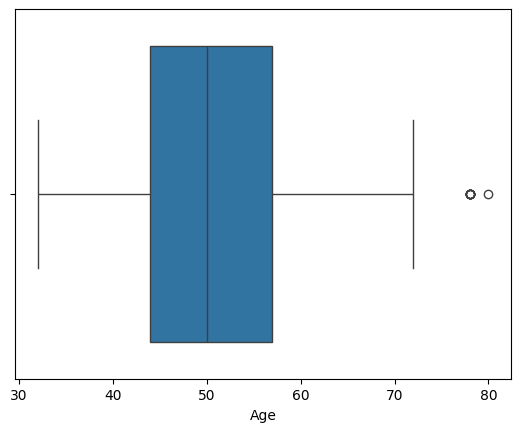

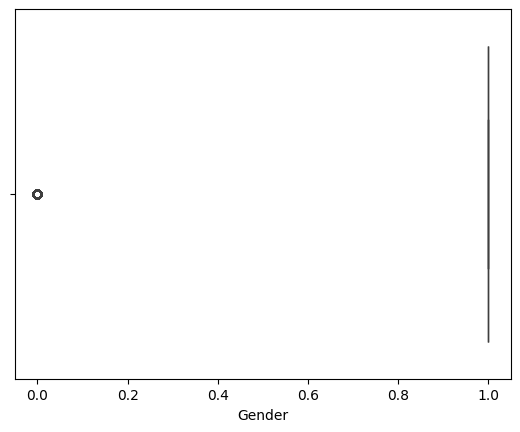

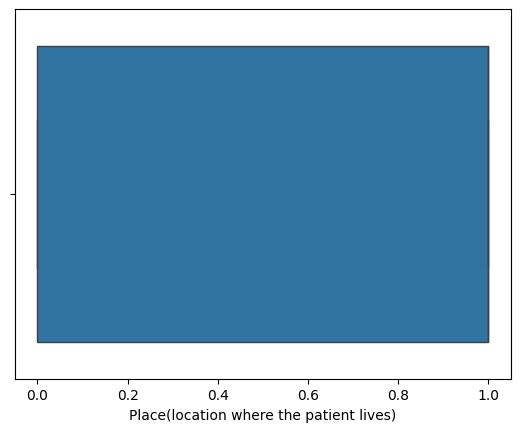

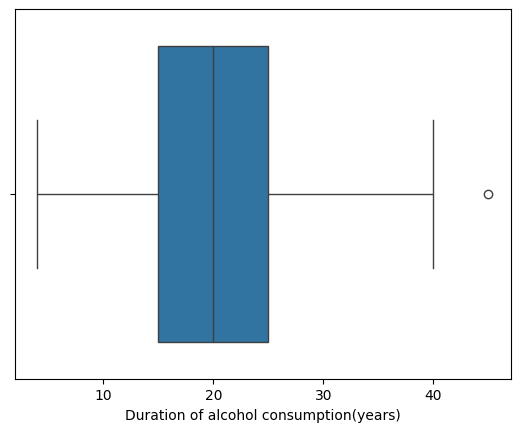

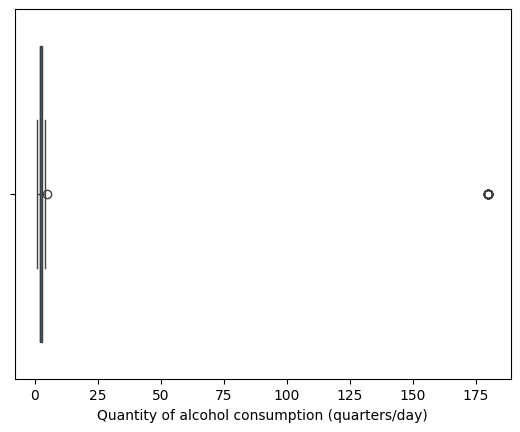

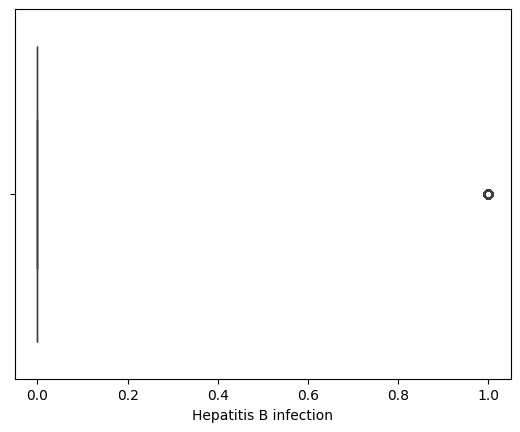

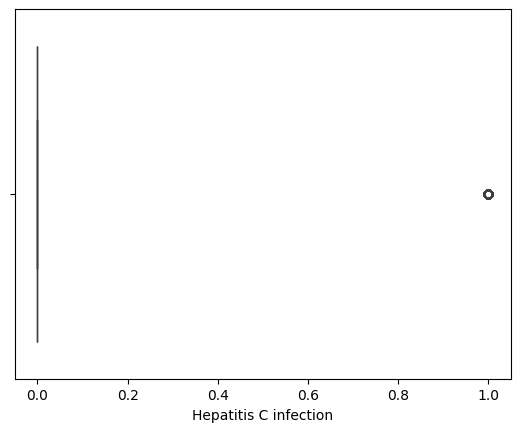

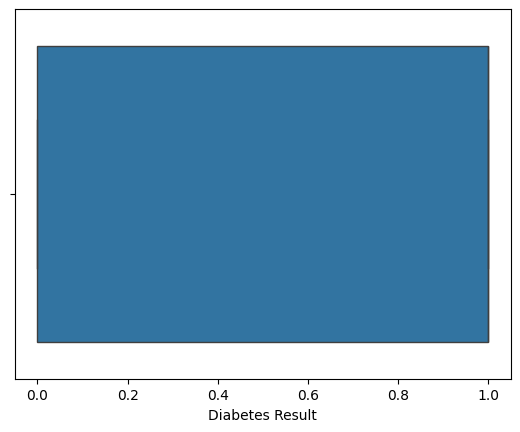

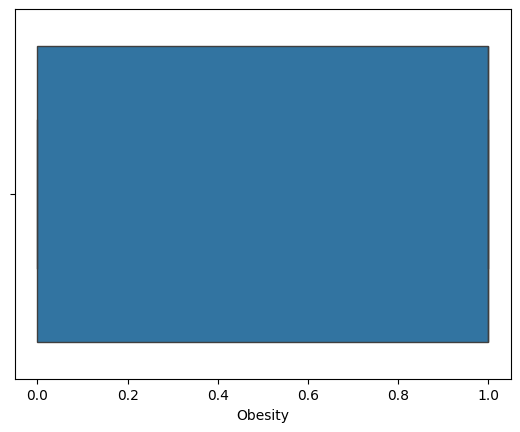

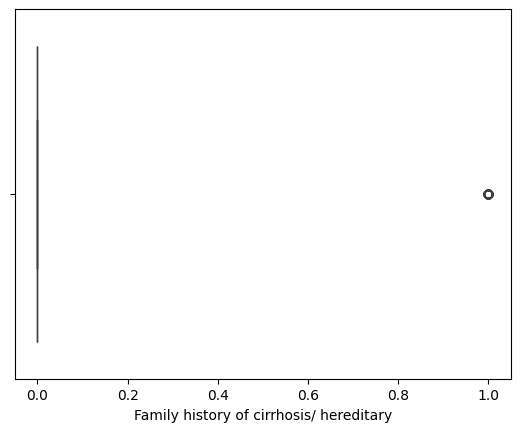

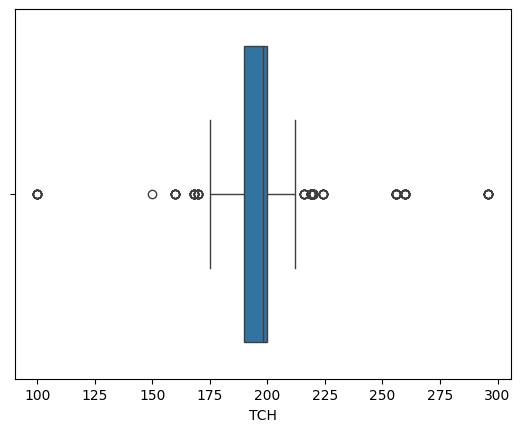

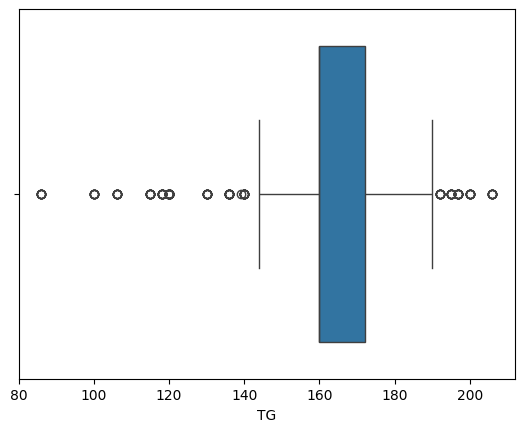

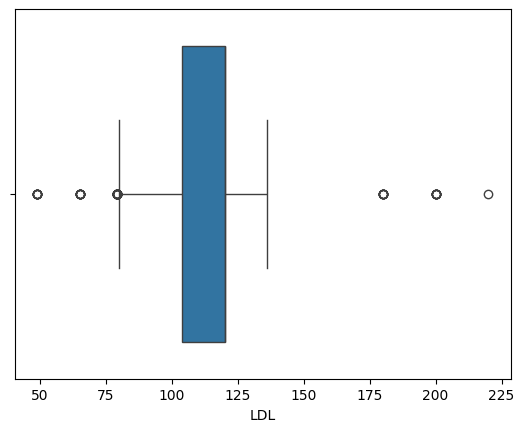

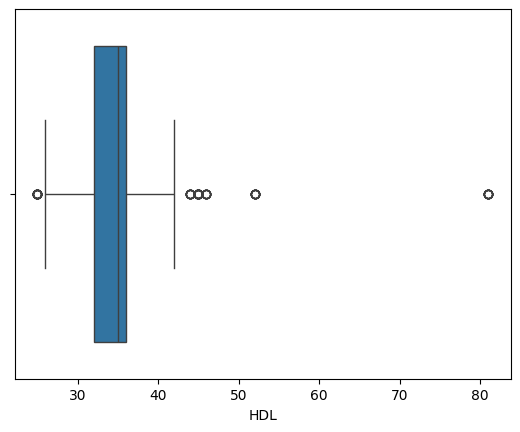

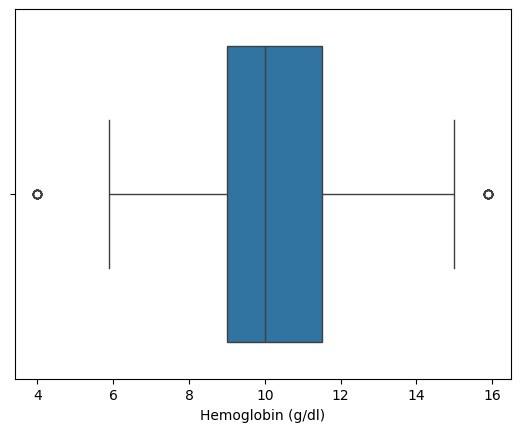

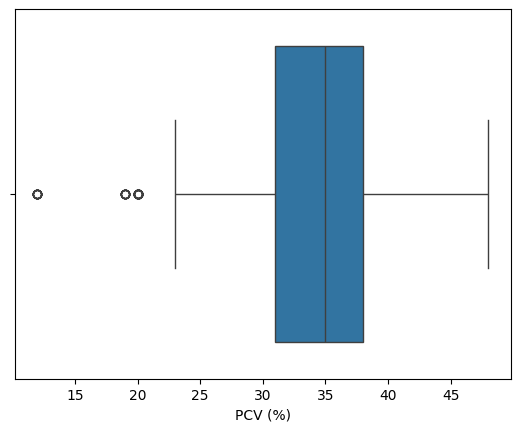

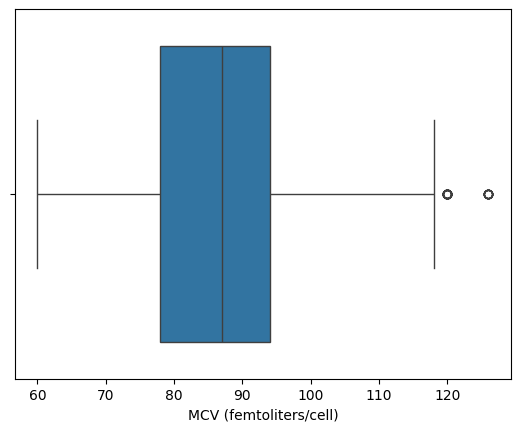

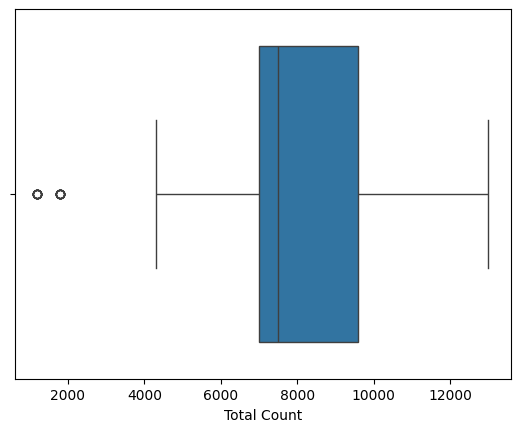

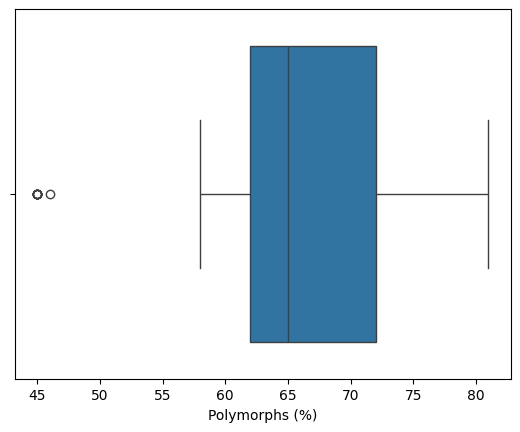

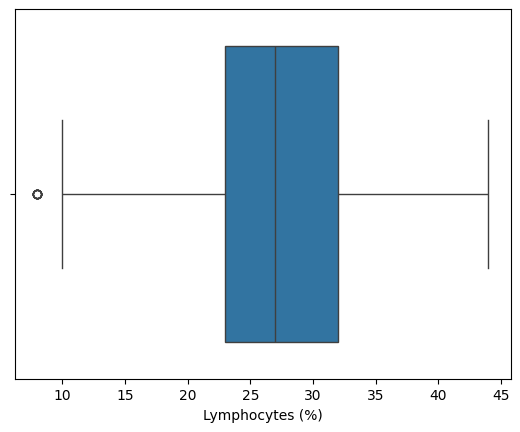

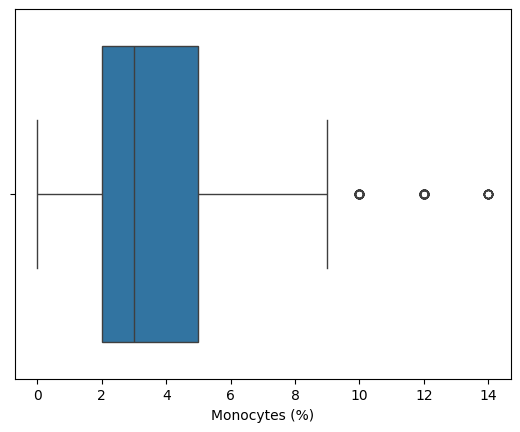

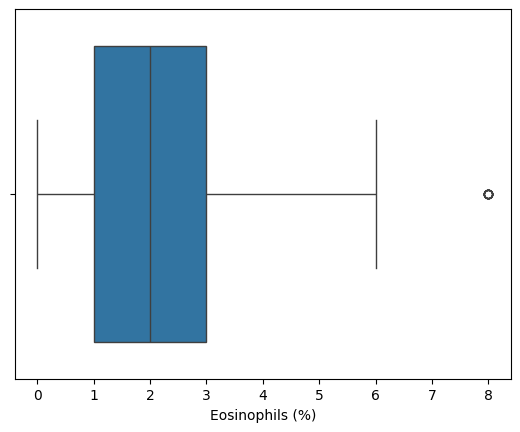

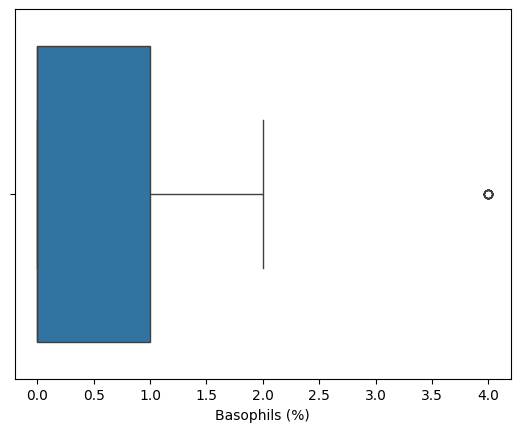

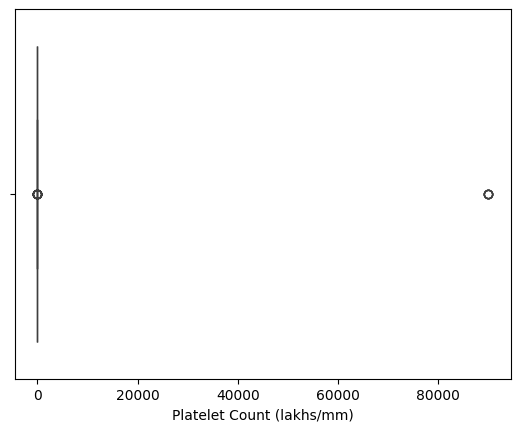

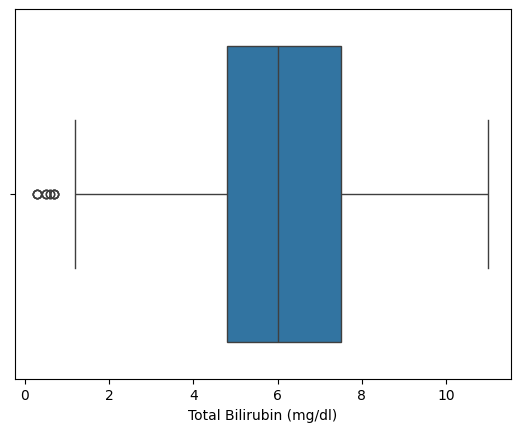

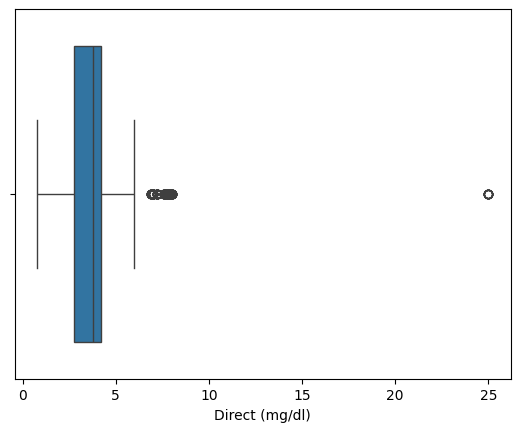

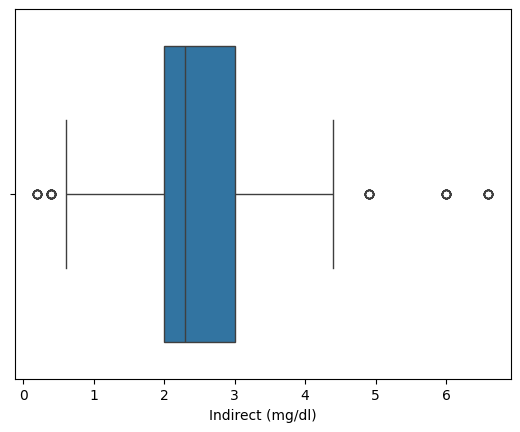

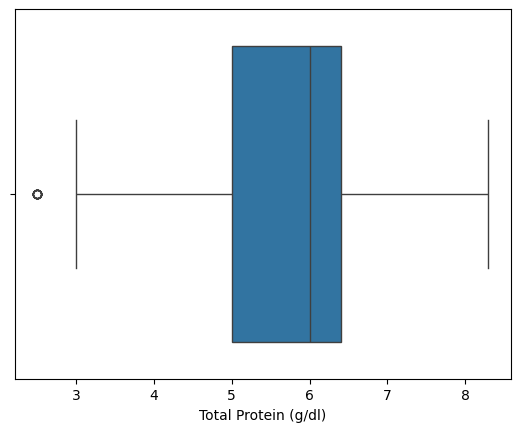

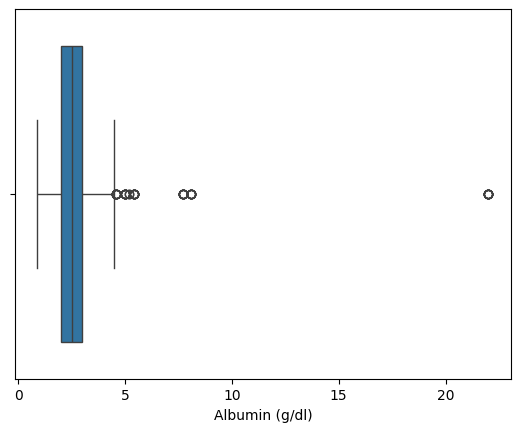

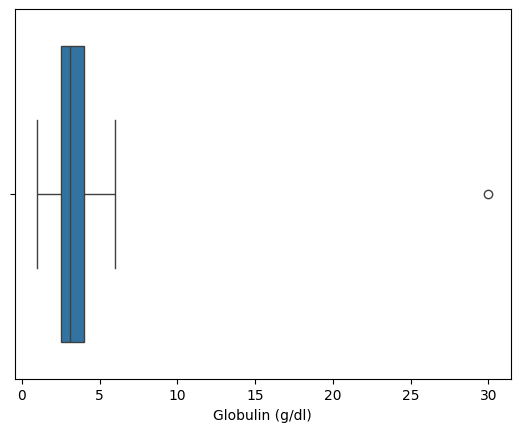

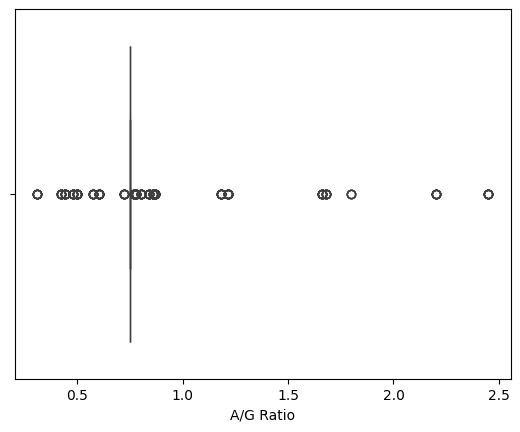

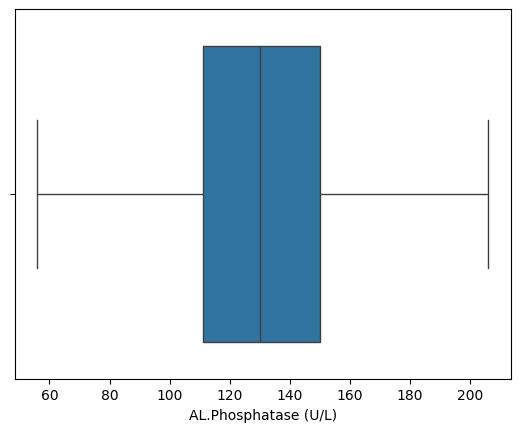

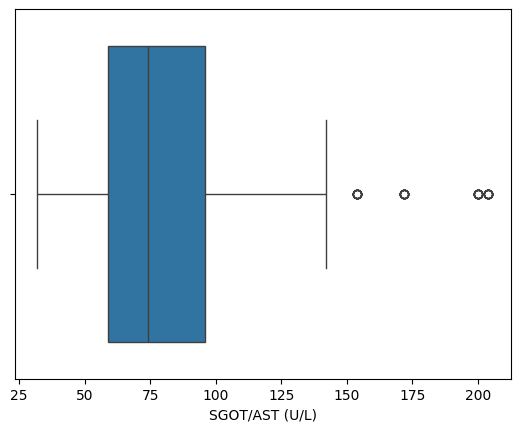

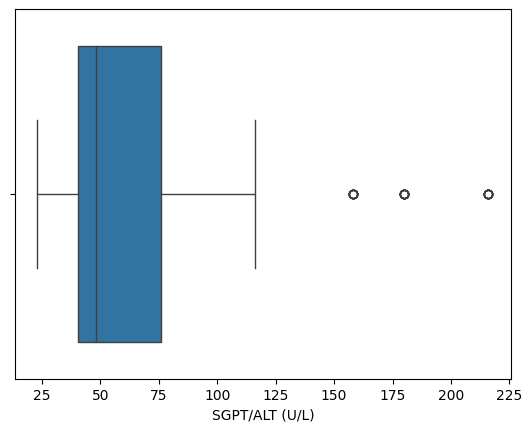

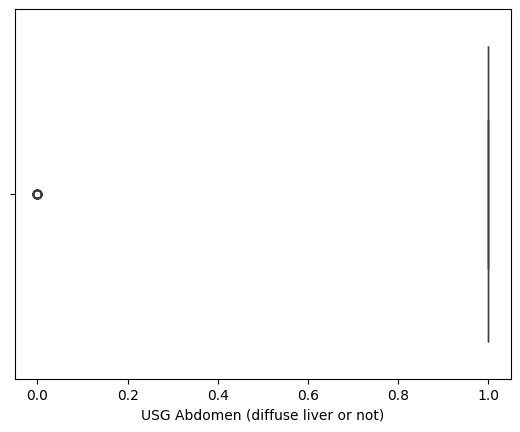

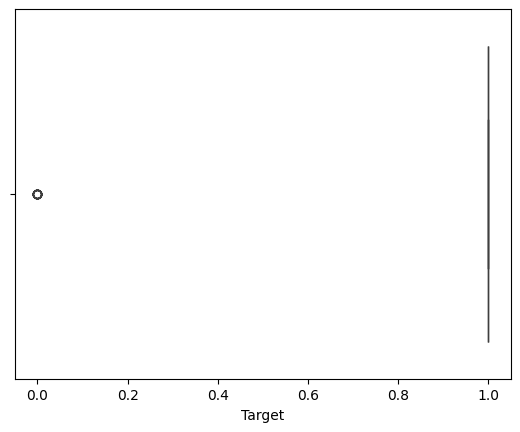

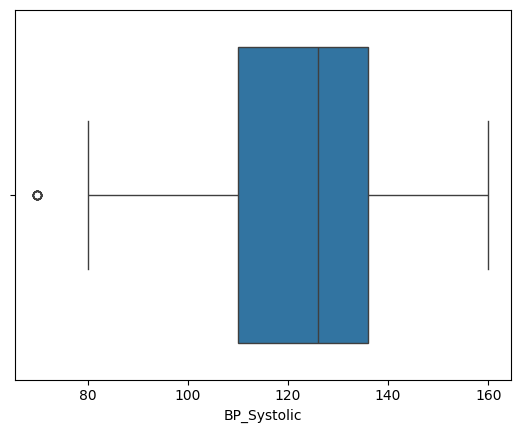

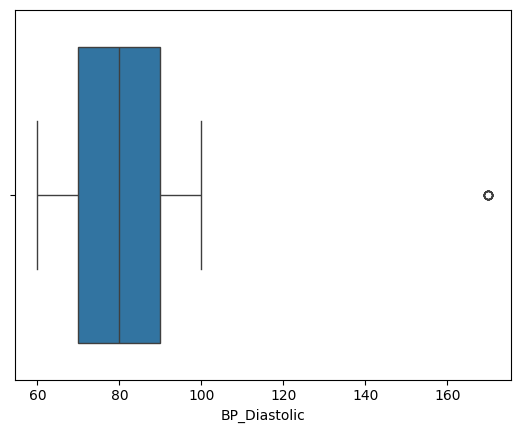

In [29]:
# Boxplot to identify Outliers
for i in df.select_dtypes(include="number").columns:
  sns.boxplot(data=df, x=i)
  plt.show()

In [30]:
# Creating function for outliers detection
def detect_outliers_iqr(df, features, threshold=1.5):
    outlier_indices = {}

    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices[col] = outliers.tolist()

        print(f"📌 {col}: {len(outliers)} outliers")

    return outlier_indices

In [31]:
# outliers detection
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
outlier_dict = detect_outliers_iqr(df, numeric_features)

📌 Age: 9 outliers
📌 Gender: 190 outliers
📌 Place(location where the patient lives): 0 outliers
📌 Duration of alcohol consumption(years): 1 outliers
📌 Quantity of alcohol consumption (quarters/day): 17 outliers
📌 Hepatitis B infection: 146 outliers
📌 Hepatitis C infection: 129 outliers
📌 Diabetes Result: 0 outliers
📌 Obesity: 0 outliers
📌 Family history of cirrhosis/ hereditary: 61 outliers
📌 TCH: 135 outliers
📌 TG: 155 outliers
📌 LDL: 65 outliers
📌 HDL: 81 outliers
📌 Hemoglobin (g/dl): 19 outliers
📌 PCV (%): 46 outliers
📌 MCV (femtoliters/cell): 36 outliers
📌 Total Count: 18 outliers
📌 Polymorphs (%): 9 outliers
📌 Lymphocytes (%): 8 outliers
📌 Monocytes (%): 73 outliers
📌 Eosinophils (%): 9 outliers
📌 Basophils (%): 9 outliers
📌 Platelet Count (lakhs/mm): 19 outliers
📌 Total Bilirubin (mg/dl): 13 outliers
📌 Direct (mg/dl): 124 outliers
📌 Indirect (mg/dl): 55 outliers
📌 Total Protein (g/dl): 10 outliers
📌 Albumin (g/dl): 55 outliers
📌 Globulin (g/dl): 1 outliers
📌 A/G Ratio: 226 outlier

In [32]:
# Function to cap outliers
def cap_outliers(df, features, threshold=1.5):
    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

In [33]:
# Capping outliers
# Get numeric features excluding the target column
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_features = [col for col in numeric_features if col != "Target"]

# Apply outlier capping only on features
df = cap_outliers(df, numeric_features)

In [ ]:
# Split Features and Target
X = df.drop(columns=["Target"])
y = df["Target"]

In [ ]:
# function for feature selection
def select_features_by_importance(X, y, top_n=20, random_state=42):
    """
    Select top N important features using Random Forest feature importances.

    Parameters:
    - X: DataFrame of features
    - y: Series or array-like target
    - top_n: number of top features to select (default: 20)
    - random_state: reproducibility

    Returns:
    - DataFrame containing only the top N important features
    """
    rf = RandomForestClassifier(random_state=random_state)
    rf.fit(X, y)

    # Create a series of importances
    importances = pd.Series(rf.feature_importances_, index=X.columns)

    # Sort and get top N
    top_features = importances.sort_values(ascending=False).head(top_n).index

    # Return filtered DataFrame
    return X[top_features]


In [ ]:
# selecting top important features
X_selected = select_features_by_importance(X, y, top_n=20)

In [ ]:
X_selected

,Total Bilirubin (mg/dl),Duration of alcohol consumption(years),Direct (mg/dl),AL.Phosphatase (U/L),Platelet Count (lakhs/mm),Indirect (mg/dl),Polymorphs (%),Albumin (g/dl),PCV (%),SGOT/AST (U/L),Lymphocytes (%),Age,Monocytes (%),BP_Systolic,Hemoglobin (g/dl),Quantity of alcohol consumption (quarters/day),Diabetes Result,Total Protein (g/dl),SGPT/ALT (U/L),Globulin (g/dl)
0,7.00,12.0,4.0,150.0,1.50,3.0,60.0,3.0,40.0,56.0,35.0,55.0,2.0,138.0,12.0,2.0,1.0,6.0,34.0,4.0
1,7.00,12.0,4.0,150.0,1.50,3.0,60.0,3.0,40.0,56.0,35.0,55.0,2.0,138.0,9.2,2.0,1.0,6.0,34.0,4.0
2,7.00,12.0,4.0,150.0,1.50,3.0,60.0,3.0,40.0,56.0,35.0,55.0,2.0,138.0,10.2,2.0,1.0,6.0,34.0,4.0
3,7.00,12.0,4.0,150.0,1.50,3.0,60.0,3.0,40.0,56.0,35.0,55.0,2.0,138.0,7.2,2.0,0.0,6.0,34.0,4.0
4,7.00,12.0,4.0,150.0,1.50,3.0,60.0,3.0,40.0,56.0,35.0,55.0,2.0,138.0,10.2,2.0,1.0,6.0,34.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,0.75,5.0,1.0,120.0,2.30,2.0,60.0,4.5,38.0,110.0,19.0,50.0,4.0,110.0,11.5,3.0,0.0,6.9,70.0,2.5
943,6.00,5.0,1.0,90.0,1.80,2.0,60.0,4.2,42.0,110.0,28.0,35.0,5.0,130.0,11.5,3.0,0.0,7.4,70.0,2.8
944,0.75,8.0,1.0,56.0,2.45,2.0,60.0,4.2,36.0,110.0,20.0,52.0,3.0,110.0,13.0,3.0,0.0,7.1,70.0,2.5
945,0.75,5.0,0.8,86.0,2.45,2.0,60.0,4.5,38.0,110.0,32.0,54.0,4.0,110.0,11.5,3.0,0.0,5.4,70.0,3.4


In [ ]:
# Split data with StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in sss.split(X_selected, y):
    X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit only on training data
X_test_scaled = scaler.transform(X_test)

In [ ]:
y_test.value_counts()

,count
Target,
1.0,174
0.0,3


In [ ]:
# Resampling to avoid class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
# Comparing multiple algorithms
def models_eval_mm(X_test_scaled, y_test, X_resampled, y_resampled):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(random_state=42),
        "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
        "SVM": SVC(probability=True, random_state=42),
        "Logistic Regression CV": LogisticRegressionCV(cv=5, max_iter=1000),
        "Ridge Classifier": RidgeClassifier(),
        "KNN": KNeighborsClassifier()
    }

    results = []

    for name, model in models.items():
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

        print(f"\n🔷 Model: {name}")
        print(f"🔹 Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
        print(f"🔹 Precision: {precision_score(y_test, y_pred):.4f}")
        print(f"🔹 Recall:    {recall_score(y_test, y_pred):.4f}")
        print(f"🔹 F1 Score:  {f1_score(y_test, y_pred):.4f}")
        if y_proba is not None:
            try:
                print(f"🔹 ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")
            except:
                print("⚠️ ROC AUC could not be calculated.")

        print(f"\n🔸 Classification Report:\n{classification_report(y_test, y_pred)}")

        results.append({
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred),
            "ROC AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None
        })

    return results


In [ ]:
results = models_eval_mm(X_test_scaled, y_test, X_resampled, y_resampled)


🔷 Model: Logistic Regression
🔹 Accuracy:  1.0000
🔹 Precision: 1.0000
🔹 Recall:    1.0000
🔹 F1 Score:  1.0000
🔹 ROC AUC:   1.0000

🔸 Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         3
         1.0       1.00      1.00      1.00       174

    accuracy                           1.00       177
   macro avg       1.00      1.00      1.00       177
weighted avg       1.00      1.00      1.00       177


🔷 Model: Random Forest
🔹 Accuracy:  1.0000
🔹 Precision: 1.0000
🔹 Recall:    1.0000
🔹 F1 Score:  1.0000
🔹 ROC AUC:   1.0000

🔸 Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         3
         1.0       1.00      1.00      1.00       174

    accuracy                           1.00       177
   macro avg       1.00      1.00      1.00       177
weighted avg       1.00      1.00      1.00       177


🔷 Model: XGBoost
🔹 Accuracy:  0.9944
🔹 

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define your models again properly in a dictionary
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Logistic Regression CV": LogisticRegressionCV(cv=5, max_iter=1000),
    "Ridge Classifier": RidgeClassifier(),
    "KNN": KNeighborsClassifier()
}

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate models using F1 score
for name, model in models.items():
    scores = cross_val_score(model, X_selected, y, scoring='f1', cv=skf)
    print(f"🔷 {name}: Mean F1 Score (CV): {scores.mean():.4f}")


🔷 Logistic Regression: Mean F1 Score (CV): 1.0000
🔷 Random Forest: Mean F1 Score (CV): 1.0000
🔷 XGBoost: Mean F1 Score (CV): 0.9988
🔷 SVM: Mean F1 Score (CV): 0.9914
🔷 Logistic Regression CV: Mean F1 Score (CV): 1.0000
🔷 Ridge Classifier: Mean F1 Score (CV): 0.9914
🔷 KNN: Mean F1 Score (CV): 1.0000


In [ ]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the base model
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',   # or use 'roc_auc', 'accuracy', etc. based on your goal
    n_jobs=-1,
    verbose=2
)

# Fit the model
grid_search.fit(X_resampled, y_resampled)

# Best model
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [ ]:
# Print best parameters
print("✅ Best Parameters:", grid_search.best_params_)

✅ Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# Make predictions on test set
y_pred = best_rf.predict(X_test_scaled)
y_proba =best_rf.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# 2. Evaluation Metrics
print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("🔹 Precision:", precision_score(y_test, y_pred))
print("🔹 Recall:", recall_score(y_test, y_pred))
print("🔹 F1 Score:", f1_score(y_test, y_pred))
print("🔹 ROC AUC Score:", roc_auc_score(y_test, y_proba))

🔹 Accuracy: 1.0
🔹 Precision: 1.0
🔹 Recall: 1.0
🔹 F1 Score: 1.0
🔹 ROC AUC Score: 1.0


In [ ]:
# 3. Confusion Matrix & Classification Report
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))


🔹 Confusion Matrix:
 [[  3   0]
 [  0 174]]

🔹 Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         3
         1.0       1.00      1.00      1.00       174

    accuracy                           1.00       177
   macro avg       1.00      1.00      1.00       177
weighted avg       1.00      1.00      1.00       177



In [ ]:
# Cross Validation
scores = cross_val_score(grid_search.best_estimator_, X_resampled, y_resampled, cv=5, scoring='roc_auc')
print("Mean AUC (CV):", scores.mean())

Mean AUC (CV): 1.0


In [ ]:
# Mannual Testing
sample_input = pd.DataFrame([{
    "Total Bilirubin (mg/dl)": 7,
    "Duration of alcohol consumption(years)": 12,
    "Direct (mg/dl)": 4,
    "AL.Phosphatase (U/L)": 150,
    "Platelet Count (lakhs/mm)": 1.5,
    "Indirect (mg/dl)": 3,
    "Polymorphs (%)": 60,
    "Albumin (g/dl)": 3,
    "PCV (%)": 40,
    "SGOT/AST (U/L)": 56,
    "Lymphocytes (%)": 35,
    "Age": 55,
    "Monocytes (%)": 2,
    "BP_Systolic": 138,
    "Hemoglobin (g/dl)": 9.2,
    "Quantity of alcohol consumption (quarters/day)": 2,
    "Diabetes Result": 1,
    "Total Protein (g/dl)": 6,
    "SGPT/ALT (U/L)": 34,
    "Globulin (g/dl)": 4
}])
sample_input2 = pd.DataFrame([{
    "Total Bilirubin (mg/dl)": 0.3,
    "Duration of alcohol consumption(years)": 8,
    "Direct (mg/dl)": 1,
    "AL.Phosphatase (U/L)": 56,
    "Platelet Count (lakhs/mm)": 3,
    "Indirect (mg/dl)": 2,
    "Polymorphs (%)": 60,
    "Albumin (g/dl)": 4.2,
    "PCV (%)": 36,
    "SGOT/AST (U/L)": 110,
    "Lymphocytes (%)": 20,
    "Age": 52,
    "Monocytes (%)": 2,
    "BP_Systolic": 110,
    "Hemoglobin (g/dl)": 13,
    "Quantity of alcohol consumption (quarters/day)": 3,
    "Diabetes Result": 0,
    "Total Protein (g/dl)": 7.1, #
    "SGPT/ALT (U/L)": 70,
    "Globulin (g/dl)": 2.5
}])

In [ ]:
sample_scaled = scaler.transform(sample_input2)

In [ ]:
# Predict
prediction = best_rf.predict(sample_scaled)
probability = best_rf.predict_proba(sample_scaled)

# Extract confidence (probability of the predicted class)
predicted_class = int(prediction[0])
confidence = probability[0][predicted_class] * 100

# Display results
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.1f}%")


Predicted Class: 0
Confidence: 98.0%


In [ ]:
# Save the Model
joblib.dump(best_rf, 'rf_acc_68.pkl')
joblib.dump(scaler, 'normalizer.pkl')

['normalizer.pkl']